In [27]:
from __future__ import division
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from scipy.special import expit
import random
from random import randint
import nltk
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
%matplotlib inline

wordnet_lemmatizer = WordNetLemmatizer()

In [2]:
def plot_cost(iter_list,cost_list):
    plt.plot(iter_list,cost_list,'r.')
    plt.xlabel('Iterations ->')
    plt.ylabel('Cost')
    plt.show()

In [3]:
def sigmoid(x):
    return expit(x)
def tanh(x):
    return np.tanh(x)


In [4]:
def activation_func(z,func='sigmoid'):
    if(func=='sigmoid'):
        return sigmoid(z)
    else:
        return tanh(z)

In [5]:
def derivative_sigmoid(z):
    g_z=sigmoid(z)
    return g_z*(1-g_z)
def derivative_tanh(z):
    g_z=tanh(z)
    return (1-g_z*g_z)

In [6]:
def mse(Y,Y_pred):
    m=len(Y)
    J = np.sum((Y_pred - Y) ** 2)/(2 * m)
    return J

In [7]:
def predict(W,b,X,dim):
    y_pred=list()
    L=len(dim)-1
    N=len(X)
    threshold=0.6
    a=dict()
    z=dict()
    
    for i in range(1,L+1):
        a[i]=np.empty(shape=[1,dim[i]])
        z[i]=np.empty(shape=[1,dim[i]])
        
        
    for n in range(N):
    # Init a[0]=x_sel,y=corresponding_y
        a[0]=X[n]
        y=Y[n]
        # Forward Pass
        for l in range(1,L+1):
            z[l]=a[l-1].dot(W[l])+b[l]
            a[l]=activation_func(z[l])
        if(a[L]>threshold):
            a[L]=-1.0
        else:
            a[L]=1.0
        y_pred.append(a[L])
    y_pred=np.asarray(y_pred)
    return y_pred

In [17]:
def neural_network(learning_rate,dim,n_epoch,activation_func_name,train_X,train_Y,test_X,test_Y):
    L=len(dim)-1
    threshold=0.6
    W=dict()
    b=dict()
    a=dict()
    z=dict()
    delta=dict()
    
    tolerance=1e-5
    cost_old=999999
    
    N=len(train_X)
    a[0]=np.empty(shape=[1,dim[0]])
    
    for i in range(1,L+1):
        W[i]=np.random.randn(dim[i-1],dim[i])/np.sqrt(dim[i-1])
        b[i]=np.ones([1,dim[i]])
        #a[i]=np.empty(shape=[1,dim[i]])
        #z[i]=np.empty(shape=[1,dim[i]])
        #delta[i]=np.empty(shape=[dim[i],1])
        
    cost_list=list()  
    iter_list=list()
    
    for epoch in range(n_epoch):
        z=zip(train_X,train_Y)
        random.shuffle(z)
        train_X,train_Y=zip(*z)
        for n in range(N):
            #n=randint(0,N-1)    

            # Init a[0]=x_sel,y=corresponding_y
            a[0]=train_X[n]
            y=train_Y[n]

            # Forward Pass
            for l in range(1,L+1):
                z[l]=a[l-1].dot(W[l])+b[l]
                #print("l ",l," z[l]",z[l])
                a[l]=activation_func(z[l])
                #print("a[l]",a[l])
            if(a[L]>threshold):
                a[L]=-1.0                # SPAM
            else:
                a[L]=1.0
                
            # Backward Pass
            delta[L]=(2*(y-a[L]))*derivative_sigmoid(z[L])
            for l in range(L-1,0,-1):
                tmp=np.asarray(np.dot(W[l+1],delta[l+1]))
                delta[l]=np.asarray(np.asarray(derivative_sigmoid(z[l])).T*tmp)

            # Update weights
            for l in range(1,L+1):
                W[l]=W[l]-learning_rate*(delta[l]*a[l-1]).T

        cost=mse(train_Y,predict(W,b,train_X,dim))
        if((abs(cost-cost_old)<tolerance and epoch>100) or cost_old==0):
            break
        cost_old=cost
        cost_list.append(cost)
        iter_list.append(epoch)
        print("Epoch: ",epoch," mse: ",cost)
    return cost_list,iter_list,W,b

    

In [9]:
def get_data():
    messages =pd.read_csv('Assignment_2_data.txt', sep='\t', quoting=csv.QUOTE_NONE,names=["label", "message"],encoding='utf8')
    word_index=dict()
    messages=shuffle(messages)
    vocab=0
    for index,rows in messages.iterrows():
        sentence=rows['message']
        tokens = nltk.word_tokenize(sentence)
        tokens=[w for w in tokens if not w in stopwords.words('english')]
        tokens=[token.lower() for token in tokens]
        wordset=[wordnet_lemmatizer.lemmatize(token) for token in tokens]
        wordset=list(set(wordset))
        for word in wordset:
            if not word in word_index:
                word_index[word]=vocab
                vocab+=1
    X=list()
    Y=list()
    for index,rows in messages.iterrows():
        sentence=rows['message']
        tokens = nltk.word_tokenize(sentence)
        tokens=[w for w in tokens if not w in stopwords.words('english')]
        tokens=[token.lower() for token in tokens]
        wordset=[wordnet_lemmatizer.lemmatize(token) for token in tokens]
        wordset=list(set(wordset))
        tmp_list=[0.0]*vocab
        #print(wordset)
        for word in wordset:
            tmp_list[word_index[word]]=1.0
        if (rows['label']=='ham'):
            Y.append(1.0)
        else:
            Y.append(-1.0)
        X.append(tmp_list)
    X=np.array(X)
    Y=np.array(Y)
    data=pd.DataFrame(X) 
    data['Y']=Y
    return X,Y,vocab,data,messages
            
        
    
    

In [10]:
def train_test_split(X,Y,ratio):
    train_length=(int)((1-ratio)*len(data))
    train_X=X[0:train_length+1]
    test_X=X[train_length+1:]
    train_Y=Y[0:train_length+1]
    test_Y=Y[train_length+1:]
    return train_X,train_Y,test_X,test_Y

In [18]:
t = int( time.time() * 1000.0 )
np.random.seed( ((t & 0xff000000) >> 24)+((t & 0x00ff0000)>>8) +((t & 0x0000ff00)<<8)+((t & 0x000000ff)<<24))
X,Y,V,data,messages=get_data()

In [19]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,9256,9257,9258,9259,9260,9261,9262,9263,9264,Y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
messages.head()

,label,message
1034,ham,"OH MR SHEFFIELD! You wanna play THAT game, oka..."
2244,ham,Boo I'm on my way to my moms. She's making tor...
2612,spam,Knock Knock Txt whose there to 80082 to enter ...
3129,ham,would u fuckin believe it they didnt know i ha...
3796,ham,Also remember the beads don't come off. Ever.


In [21]:
train_X,train_Y,test_X,test_Y=train_test_split(X,Y,0.2)

('Epoch: ', 0, ' mse: ', 0.10627802690582959)
('Epoch: ', 1, ' mse: ', 0.041255605381165919)
('Epoch: ', 2, ' mse: ', 0.026008968609865471)
('Epoch: ', 3, ' mse: ', 0.031390134529147982)
('Epoch: ', 4, ' mse: ', 0.074439461883408067)
('Epoch: ', 5, ' mse: ', 0.028251121076233184)
('Epoch: ', 6, ' mse: ', 0.011659192825112108)
('Epoch: ', 7, ' mse: ', 0.051121076233183856)
('Epoch: ', 8, ' mse: ', 0.0067264573991031393)
('Epoch: ', 9, ' mse: ', 0.0080717488789237672)
('Epoch: ', 10, ' mse: ', 0.01031390134529148)
('Epoch: ', 11, ' mse: ', 0.013452914798206279)
('Epoch: ', 12, ' mse: ', 0.012556053811659192)
('Epoch: ', 13, ' mse: ', 0.0040358744394618836)
('Epoch: ', 14, ' mse: ', 0.0035874439461883408)
('Epoch: ', 15, ' mse: ', 0.0062780269058295961)
('Epoch: ', 16, ' mse: ', 0.0031390134529147981)
('Epoch: ', 17, ' mse: ', 0.0035874439461883408)
('Epoch: ', 18, ' mse: ', 0.0013452914798206279)
('Epoch: ', 19, ' mse: ', 0.014349775784753363)
('Epoch: ', 20, ' mse: ', 0.0013452914798206

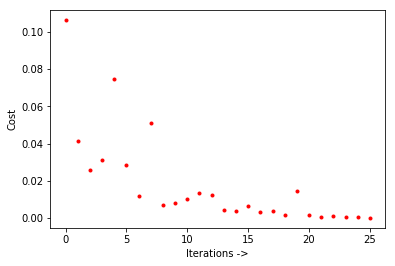

In [23]:
dim=[V,100,50,1]
cost_list,iter_list,W,b=neural_network(0.1,dim,1000,'sigmoid',train_X,train_Y,test_X,test_Y)
plot_cost(iter_list,cost_list)

In [ ]:
plot_cost(iter_list,cost_list)

In [26]:
test_Y

array([ 1., -1., -1., ...,  1.,  1., -1.])

In [28]:
accuracy_score(test_Y,y_pred,normalize=True)

0.97755834829443444